In [3]:
### trade one stock OCB 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import gc
from scipy.stats import nct, laplace_asymmetric
from typing import List
import pandas_ta as ta
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import datetime
import calendar

import plotly.graph_objects as go
import plotly.subplots as sp

from app.historical_price import HistoricalPrice
from app.random_variable import RandomVariable

In [608]:

### WEEKLY ####
# pair = ['PVS','PLX'][::-1] ###  Oil Equipment, Services & Distribution --> Oil & Gas producers
# pair = ['VCG','DIG']#[::-1] ###  Construction & Materials --> Real Estate
# pair = [VGS','TLH'] ### INDUSTRIAL METALS-> INDUSTRIAL METALS, HNX HOSE
# pair = ['CTS','FTS'] ###  RFINANCIAL SERVICES -> FINANCIAL SERVICES
# pair = ['MBS','BSI'] ### FINANCIAL SERVICES -> FINANCIAL SERVICES


### MONTHLY ####
# pair = ['PLP','DRH'] 
# pair = ['TTH','QBS']
# pair = ['HAP','EVG']
# pair = ['GSP','NSH']
# pair =['TNI','ITQ']
pair

['ITQ', 'TNI']

In [609]:
hp = HistoricalPrice()
daily_returns = hp.get_returns(freq='daily',tickers=pair)
weekly_returns = hp.get_returns(freq='weekly',tickers=pair)
monthly_returns = hp.get_returns(freq='monthly',tickers=pair)

### TEST correlated asset pair

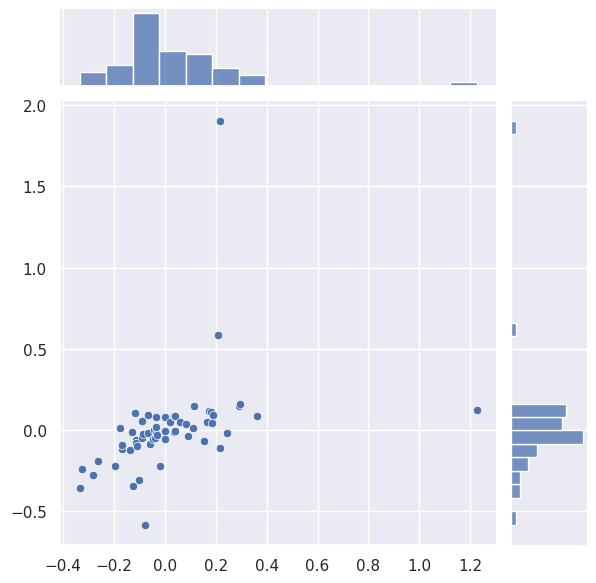

In [610]:
M = monthly_returns.loc[:,pair].sort_values(by=[pair[0]],ascending=True)
M[pair[0]] = M[pair[0]].shift(0)
M = M.dropna().values
sns.jointplot(x=M[:,0],y=M[:,1])

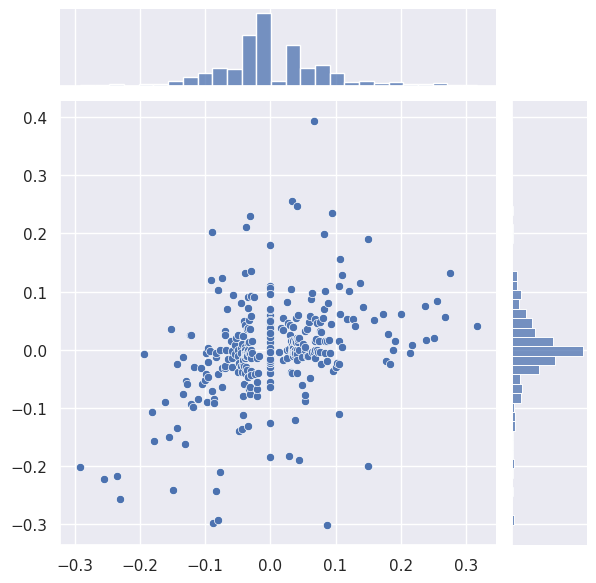

In [611]:
W = weekly_returns.loc[:,pair].sort_values(by=[pair[0]],ascending=True)
W[pair[0]] = W[pair[0]].shift(0)
W = W.dropna().values
sns.jointplot(x=W[:,0],y=W[:,1])

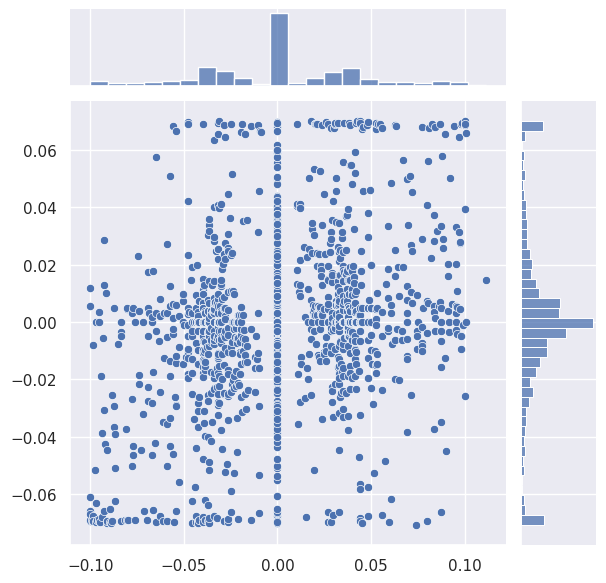

In [612]:
D = daily_returns.loc[:,pair].sort_values(by=[pair[0]],ascending=True)
D[pair[0]] = D[pair[0]].shift(0)
D = D.dropna().values
sns.jointplot(x=D[:,0],y=D[:,1])

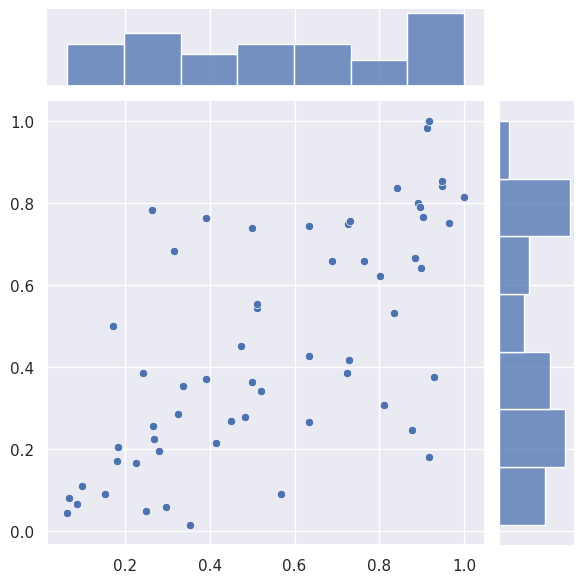

In [613]:
import pyvinecopulib as pv
from scipy.stats import gennorm,laplace_asymmetric

X = M.copy()
variables = [RandomVariable(X[:,i],gennorm) for i in range(X.shape[1])]
uniform = [var.unif() for var in variables]
sns.jointplot(x=uniform[0],y=uniform[1])

In [614]:
array = np.vstack((uniform[0],uniform[1])).T
array.shape

(59, 2)

In [615]:
bicop = pv.Bicop()
bicop.select(array)

In [616]:
bicop.str(),bicop.loglik()

('Gumbel 180°, parameters = 1.83004', 15.212828766079532)

In [617]:
sample = bicop.simulate(n=100000)
sample.shape

(100000, 2)

In [618]:
sim_returns = [variables[i].transform(sample[:,i]) for i in range(sample.shape[1])]
sim_returns = pd.DataFrame(np.vstack((sim_returns[0],sim_returns[1])).T,columns=pair)
sim_returns.head()

,ITQ,TNI
0,-0.065981,0.037801
1,0.078675,-0.142794
2,-0.113535,-0.032485
3,-0.058559,-0.075587
4,-0.214864,-0.362825


Text(0, 0.5, 'frequency (days or weeks)')

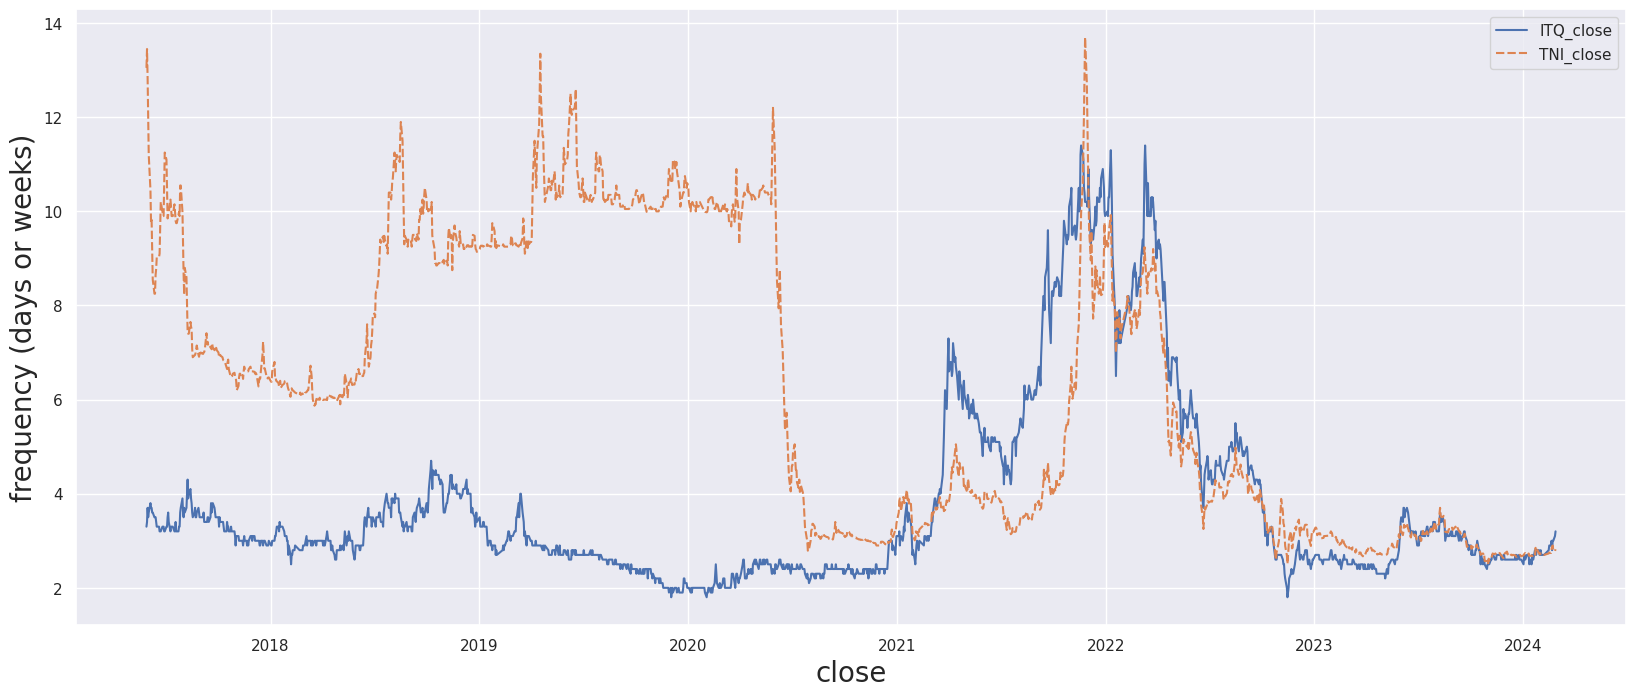

In [619]:
freq = 'daily'
price_0 = hp.get_asset_price(pair[0],freq)
price_1 = hp.get_asset_price(pair[1],freq)

res_plot = pd.concat([price_0[['close','open']],price_1[['close','open']]],axis=1).dropna()
res_plot.columns = [f"{pair[0]}_close",f"{pair[0]}_open",f"{pair[1]}_close",f"{pair[1]}_open"]

sns.set(rc={'figure.figsize':(20,8)})
plot = sns.lineplot(data=res_plot[[f"{pair[0]}_close",f"{pair[1]}_close"]])
plot.set_xlabel('close', fontsize = 20)
plot.set_ylabel('frequency (days or weeks)', fontsize = 20)

In [620]:
def func(x, a, b ):
    return a*x**2 + b*x

[-0.62436559  0.89853026] 6.166892704236322 0.06853935711135371 0.11826404328917357


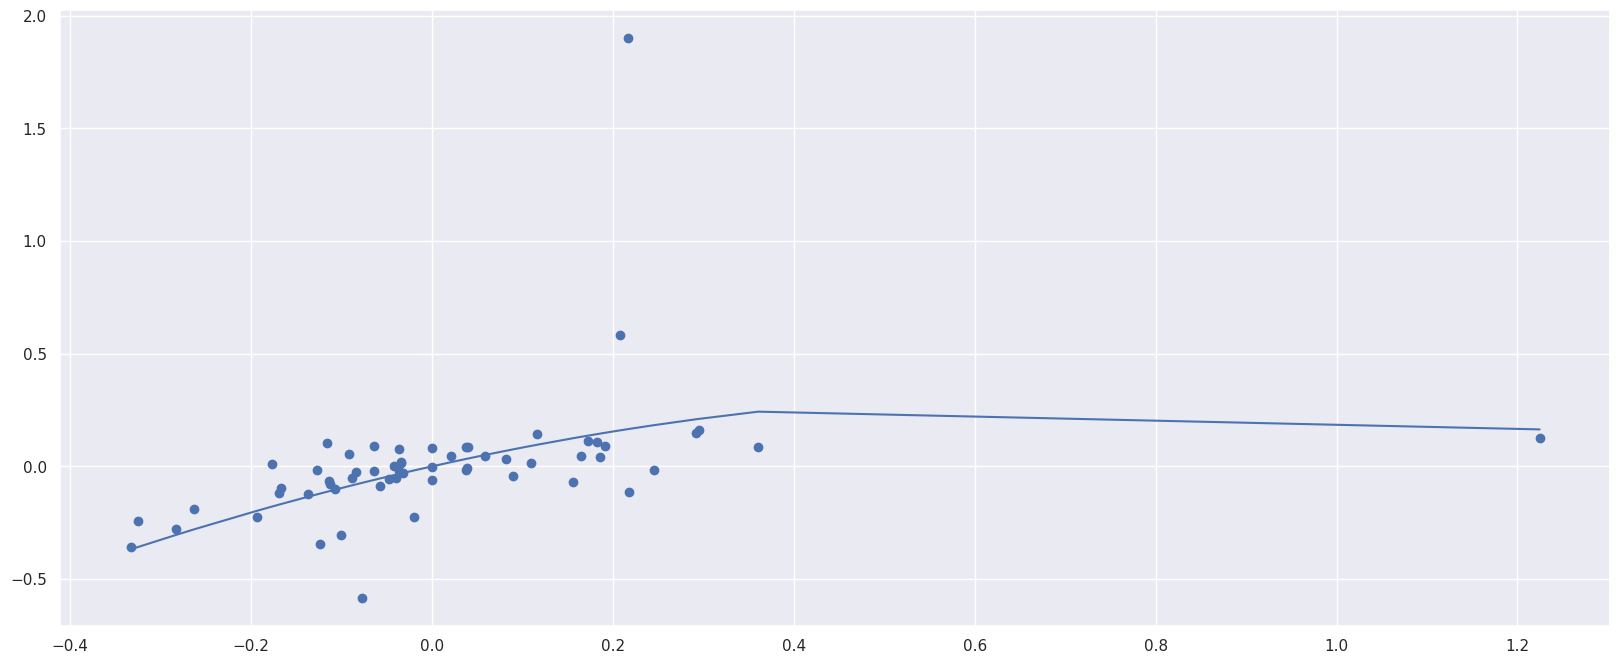

In [621]:
# remove outliers
# X = X[(X[:, 0] <0.4),:] ## MBS
# X = X.loc[(X[pair[0]]<1)&(X[pair[1]]<0.6)]
# X = X.loc[(X[pair[1]]<0.7)]

popt, pcov = curve_fit(func, X[:,0], X[:,1])

pred = func(X[:,0], *popt)
print(popt,np.linalg.cond(pcov),mean_squared_error(X[:,1],pred),mean_absolute_error(X[:,1],pred))
plt.scatter(X[:,0], X[:,1],color='b')
# plt.scatter(sim_returns[pair[0]], sim_returns[pair[1]],color='r')
plt.plot(X[:,0], pred )

In [622]:
# X = X[(X[:, 0] <0.4),:]

# popt, pcov = curve_fit(func, sim_returns[pair[0]], sim_returns[pair[1]])
# pred = func(X[:,0], *popt)

# print(popt,np.linalg.cond(pcov),mean_squared_error(X[:,1],pred),mean_absolute_error(X[:,1],pred))
# plt.scatter(X[:,0], X[:,1],color='b')
# # plt.scatter(sim_returns[pair[0]], sim_returns[pair[1]],color='r')
# plt.plot(X[:,0], pred )

In [623]:
from hmmlearn import hmm
import logging
logging.getLogger("hmmlearn").setLevel("CRITICAL")

class GMMHMM:
    def set_column_features(self, df: pd.DataFrame):
        self.cols = [i for i in df.columns if "direction" in i]

    def feature_engineer(self, df: pd.DataFrame, lag: int) -> pd.DataFrame:
        """
        USE GMMHMM to cluster states based on directional change.
        """
        df = df.dropna(subset=["close"])
        df = self.get_direction(df, lag)
        self.set_column_features(df)
        return df

    def point_predict(self, val: float) -> pd.DataFrame:
        return self.model.predict(np.array(val).reshape(1, -1))

    def batch_predict(self, df: pd.DataFrame) -> pd.DataFrame:
        df["states"] = self.model.predict(df.loc[:, self.cols])
        return df

    def post_processing(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create two columns, one for each state. y
        """
        states = pd.get_dummies(df["states"])
        states.columns = ["state_0", "state_1"]
        states_onehot = df["close"].multiply(states.T).T
        states_onehot[states_onehot == 0] = np.nan
        df = pd.concat([df, states_onehot], axis=1)
        df.index = pd.DatetimeIndex(df.index).to_period("D")
        df.index = df.index.to_timestamp()
        return df

    def get_direction(self, df: pd.DataFrame, lag: int) -> pd.DataFrame:
        """
        Get weighted moving average of the last 'lag' points.
        Obtain lagged returns and directional change.
        """
        df[f"ma_{lag}"] = df.ta.wma(lag)
        df[f"returns_{lag}"] = df["close"] / df[f"ma_{lag}"].shift(lag) - 1
        df[f"directional_change_{lag}"] = df[f"returns_{lag}"] / np.abs(
            df[f"returns_{lag}"]
        )
        return df.fillna(method="bfill").dropna()

    def get_best_model(self, df: pd.DataFrame) -> None:
        """
        Fit GMMHMM 10000 times and pick the best model.
        (minimize randomness)
        """
        best_mle = -100000
        best_model = None
        for i in range(100):
            try:
                model = hmm.GMMHMM(n_components=2, n_iter=10000)
                model.fit(df.loc[:, self.cols])
                mle = model.score(df.loc[:, self.cols])
                if mle > best_mle:
                    best_mle = mle
                    best_model = model
            except Exception:
                continue
        self.model = best_model

    def plot_cluster(self, df: pd.DataFrame) -> None:
        df = self.post_processing(df)
        fig = go.Figure()
        fig = sp.make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df["state_0"], mode="markers", marker=dict(color="blue")
            )
        )
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df["state_1"], mode="markers", marker=dict(color="red")
            )
        )
        fig.update_layout(
            xaxis_title="Date",
            yaxis_title="Closing Prices",
            height=750,
            width=1250,
        )
        fig.show()

    def save_model(self, path: str) -> None:
        pickle.dump(self.model, open(path, "wb"))

    def load_model(self, path: str) -> None:
        self.model = pickle.load(open(path, "rb"))


gmmhmm =GMMHMM()
p = gmmhmm.feature_engineer(price_1.copy(), lag=3)
gmmhmm.get_best_model(p)
states = gmmhmm.batch_predict(p)

p = gmmhmm.feature_engineer(price_1.copy(), lag=5)
gmmhmm.get_best_model(p)
states_10 = gmmhmm.batch_predict(p)

p = gmmhmm.feature_engineer(price_1.copy(), lag=10)
gmmhmm.get_best_model(p)
states_20 = gmmhmm.batch_predict(p)

p = gmmhmm.feature_engineer(price_1.copy(), lag=200)
gmmhmm.get_best_model(p)
states_200 = gmmhmm.batch_predict(p)



In [624]:
states['states_3'] = states['states']
states['states_5'] = states_10['states']
states['states_10'] = states_20['states']
states['states_200'] = states_200['states']
states.head()

,low,high,open,close,adj_close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,ma_3,returns_3,directional_change_3,states,states_3,states_5,states_10,states_200
date,,,,,,,,,,,,,,,,,
2017-05-29,11.00,13.05,11.40,13.05,12.47,5124680,63003000000,0,0,13.083333,-0.201274,-1.0,1,1,0,1,0
2017-05-30,13.05,13.95,13.25,13.45,12.86,4453270,60549000000,0,0,13.083333,-0.201274,-1.0,1,1,0,1,0
2017-05-31,12.85,13.85,13.50,12.85,12.28,1562860,21020000000,0,0,13.083333,-0.201274,-1.0,1,1,0,1,0
2017-06-01,12.00,12.00,12.00,12.00,11.47,743410,8921000000,0,0,12.525000,-0.201274,-1.0,1,1,0,1,0
2017-06-02,11.20,11.20,11.20,11.20,10.71,924640,10356000000,0,0,11.741667,-0.201274,-1.0,1,1,0,1,0


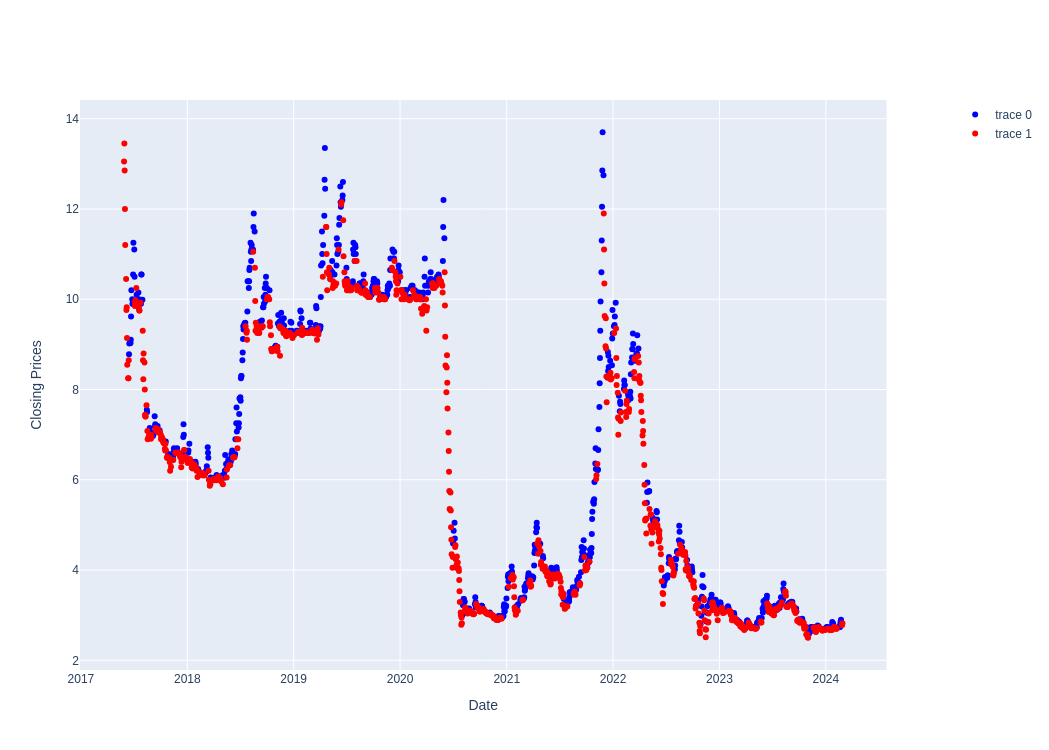

In [625]:
gmmhmm.plot_cluster(states)

## Weekly Correlated Pair

In [626]:
############################## WEEKLY TRADING #######################

### VARIABLE POSITION SIZING IS ALWAYS BETTER THAN FIXED
### TRANSACTION FEES 0.1% for buy/sell, and TAX (for sell) not incoporated yet

# prices = res_plot.dropna().iloc[500:]
prices = pd.concat([states,res_plot],axis=1).dropna().iloc[500:]
prices['date'] = prices.index
prices['week'] = prices.apply(lambda row: row['date'].isocalendar()[1],axis=1)
# prices = res_plot.loc['2020-01-01':'2022-03-01'] #### IF trade during bull market only then returns = 9.92
# prices = res_plot.loc['2022-01-01':'2022-11-01'] #### IF trade during bear market only then returns = -0.039

print(len(prices))
initial_capital = 3000000

capital = initial_capital
shares = [0,0]
total = capital 
start_total = total
last_bought_price = None
last_bought_day = None

multiplier = 10

trading_weekly_returns = {}
trading_accum_returns = {}
deviation = []
actions = {}
temp_returns =pd.DataFrame(data=None,columns=['return_x','return_y','pred_return_y','mult*pred_return_y'])

for i in range(0,len(prices)):
    action = None
    today = prices.index[i]
    if i==0:
        week = prices.loc[today,'week']
    
    ### IF new week
    if week != prices.loc[today,'week']:
        """
            Record last week returns
        """
        trading_weekly_returns[week] = total/start_total - 1
        trading_accum_returns[week] = total/initial_capital - 1
        start_total = total        
        
        """
            START NEW WEEK 
            - Reset days_past
            - Use last week closing as this week opening
        """
        first_date = today = today.strftime('%Y-%m-%d')
        week = prices.loc[today,'week']
        days_past = 1
        week_open_pair0 = prices.loc[first_date,f"{pair[0]}_open"]
        week_open_pair1 = prices.loc[first_date,f"{pair[1]}_open"]
    else:
        days_past += 1
    
    ## Daily return (so far for this week)
    return_x = (prices.loc[today,f"{pair[0]}_close"]/week_open_pair0)**(1/days_past)-1
    return_y = (prices.loc[today,f"{pair[0]}_close"]/week_open_pair1)**(1/days_past)-1

    ### 1) USE x-returns from start of week till now, to infer x-returns for the whole week
    ### 2) USE expected monthly x to obtain expected monthly y returns.
    ### 3) USE expected monthly y returns, to obtain expected daily y returns
    weekly_return_x = (1+return_x)**(5)-1
    # pred_monthly_return_y = sim_returns.loc[(sim_returns[pair[0]]<weekly_return_x+0.000001)&(sim_returns[pair[0]]>weekly_return_x-0.000001),pair[1]].mean()
    # if np.isnan(pred_monthly_return_y):
    pred_weekly_return_y = func(weekly_return_x,*popt)


    pred_return_y = (1+pred_weekly_return_y)**(1/5)-1
    dev = pred_return_y - return_y
    deviation.append(dev)
    price_per_share= prices.loc[today,f"{pair[1]}_close"]*1000


    state_3 = prices.loc[today,'states_3']
    state_10 = prices.loc[today,'states_5']
    state_20 = prices.loc[today,'states_10']
    state_200 = prices.loc[today,'states_200']
    temp_returns.loc[len(temp_returns),:] = [return_x,return_y,pred_return_y,multiplier*pred_return_y]


    #### Y is overvalued by a factor of 5
    if return_y >= multiplier*pred_return_y: 
        ### X increasing, means Y will increase soon. Hold Y. 
        ### Because X & Y are positive-correlated. If x > 0 then y > 0 also.
        ### Wait for a sell signal. 
        if return_y > 0:
            action="HOLD_1"
        ### X decreasing, means Y will likely decrease also. Sell Y
        ### Because X and Y are positive-correlated. If x < 0 then y will be < 0 eventually. 
        ### So we sell y while it is extremely overvalued, before it decreases
        else:
            amount = shares[1]
            if amount >0:# and (state_3==0 and state_10==0 and state_200==1):
                action="SELL"
                capital+=price_per_share*amount
                shares[1]-=amount
            else: 
                action="HOLD_2"

    ### Y is undervalued.
    ### There's a high chance that Y will become overvalued by a factor of 5 at some point,
    ### so we can be confident and buy whenever Y is undervalued below the multiplier line.
    elif return_y < multiplier*pred_return_y:
        ### X and Y are moving in opposite directions. 
        if return_y*return_x < 0:
            action="HOLD_3"
        ### X and Y are moving in the same direction (i.e. both are increasing/decreasing)
        ### If increase, because Y is undervalued it will increase relatively more from now on. BUY
        ### If decrease, because Y is undervalued it will decrease relatively less, but still decreasing. BUY
        else:
            # [-1.252, -1.062, -0.467, 0.289, 0.487, 0.552]
            position_sizing = min((np.abs(dev)/0.1),1)
            amount = np.floor(position_sizing*capital/price_per_share)
            if amount > 0:# and (state_3==1 and state_10==0 and state_20==1):
                action = "BUY"
                shares_value = price_per_share*(amount)
                capital-=shares_value
                shares[1]+=amount
            else:
                action="HOLD_4"

    new_total = capital + price_per_share*shares[1]
    prices.loc[today,'action'] = action
    if action not in actions:
        actions[action] = {'count':0,'value':0}

    actions[action]['count'] += 1
    actions[action]['value'] += new_total - total
    total = new_total

import json
print(capital,shares,total)
print("total returns:",(total/initial_capital)-1)
print("annualized returns:",(total/initial_capital)**(250/len(prices))-1)
print(json.dumps(actions,indent=4))

1182
18330.0 [0, 568.0] 1620090.0
total returns: -0.45997
annualized returns: -0.12218136052141781
{
    "HOLD_2": {
        "count": 109,
        "value": 0.0
    },
    "BUY": {
        "count": 199,
        "value": 928770.0
    },
    "HOLD_4": {
        "count": 336,
        "value": -103010.00000000023
    },
    "HOLD_3": {
        "count": 198,
        "value": -552720.0
    },
    "SELL": {
        "count": 58,
        "value": -941050.0
    },
    "HOLD_1": {
        "count": 282,
        "value": -711899.9999999998
    }
}


## Monthly Correlated Pair

In [627]:
### VARIABLE POSITION SIZING IS ALWAYS BETTER THAN FIXED

# prices = res_plot.dropna().iloc[500:]
prices = pd.concat([states,res_plot],axis=1).dropna().iloc[500:]
# prices = res_plot.loc['2020-01-01':'2022-03-01'] #### IF trade during bull market only then returns = 9.92
# prices = res_plot.loc['2022-01-01':'2022-11-01'] #### IF trade during bear market only then returns = -0.039

print(len(prices))
initial_capital = 3000000

capital = initial_capital
shares = [0,0]
total = capital 
start_total = total
last_bought_price = None
last_bought_day = None

multiplier = 3.5

trading_monthly_returns = {}
trading_accum_returns = {}
deviation = []
actions = {}
temp_returns =pd.DataFrame(data=None,columns=['return_x','return_y','pred_return_y','mult*pred_return_y'])

for i in range(0,len(prices)):
    action = None
    today = prices.index[i]
    year = today.year
    month = str(today.month).zfill(2)
    
    ### Not sure why, but changing Last, can lead to significant changes in returns 
    last = calendar.monthrange(today.year,today.month)[1]

    first_date = prices.loc[f"{year}-{month}-01":,:].index[0]
    today = today.strftime('%Y-%m-%d')
    temp = prices.loc[first_date:today,:]
    
    days_past = len(temp)-1
    if temp.index[0].day > 5:
        continue
    
    if days_past>0:
        ## Accum Return from start of month till TODAY
        return_x = (prices.loc[today,f"{pair[0]}_close"]/prices.loc[first_date,f"{pair[0]}_close"])**(1/days_past)-1
        return_y = (prices.loc[today,f"{pair[1]}_close"]/prices.loc[first_date,f"{pair[1]}_close"])**(1/days_past)-1

        ### 1) USE x-returns from start of month till now, to infer x-returns for the whole month
        ### 2) USE expected monthly x to obtain expected monthly y returns.
        ### 3) USE expected monthly y returns, to obtain expected daily y returns
        monthly_return_x = (1+return_x)**(last-1)-1
        # pred_monthly_return_y = sim_returns.loc[(sim_returns[pair[0]]<monthly_return_x+0.00001)&(sim_returns[pair[0]]>monthly_return_x-0.00001),pair[1]].mean()
        # if np.isnan(pred_monthly_return_y):
        pred_monthly_return_y = func(monthly_return_x,*popt)
        
        
        pred_return_y = (1+pred_monthly_return_y)**(1/(last-1))-1
        dev = pred_return_y - return_y
        deviation.append(dev)
        price_per_share= prices.loc[today,f"{pair[1]}_close"]*1000
        
        
        state_3 = prices.loc[today,'states_3']
        state_10 = prices.loc[today,'states_5']
        state_20 = prices.loc[today,'states_10']
        state_200 = prices.loc[today,'states_200']
        temp_returns.loc[len(temp_returns),:] = [return_x,return_y,pred_return_y,multiplier*pred_return_y]
        

        #### Y is overvalued by a factor of 5
        if return_y >= multiplier*pred_return_y: 
            ### X increasing, means Y will increase soon. Hold Y. 
            ### Because X & Y are positive-correlated. If x > 0 then y > 0 also.
            ### Wait for a sell signal. 
            if return_y > 0:
                action="HOLD_1"
            ### X decreasing, means Y will likely decrease also. Sell Y
            ### Because X and Y are positive-correlated. If x < 0 then y will be < 0 eventually. 
            ### So we sell y while it is extremely overvalued, before it decreases
            else:
                amount = shares[1]
                if amount >0:# and (state_3==0 and state_10==0 and state_200==1):
                    action="SELL"
                    capital+=price_per_share*amount
                    shares[1]-=amount
                else: 
                    action="HOLD_2"

        ### Y is undervalued.
        ### There's a high chance that Y will become overvalued by a factor of 5 at some point,
        ### so we can be confident and buy whenever Y is undervalued below the multiplier line.
        elif return_y < multiplier*pred_return_y:
            ### X and Y are moving in opposite directions. 
            if return_y*return_x < 0:
                action="HOLD_3"
            ### X and Y are moving in the same direction (i.e. both are increasing/decreasing)
            ### If increase, because Y is undervalued it will increase relatively more from now on. BUY
            ### If decrease, because Y is undervalued it will decrease relatively less, but still decreasing. BUY
            else:
                position_sizing = min((np.abs(dev)/0.02),1)
                amount = np.floor(position_sizing*capital/price_per_share)
                if amount > 0:# and (state_3==1 and state_10==0 and state_20==1):
                    action = "BUY"
                    shares_value = price_per_share*(amount)
                    capital-=shares_value
                    shares[1]+=amount
                else:
                    action="HOLD_4"


                    
        new_total = capital + price_per_share*shares[1]
        prices.loc[today,'action'] = action
        if action not in actions:
            actions[action] = {'count':0,'value':0}
            
        ### BEGINNING OF MONTH
        if today==temp.index[1].strftime('%Y-%m-%d'):
            trading_monthly_returns[temp.index[1]] = total/start_total - 1
            trading_accum_returns[temp.index[1]] = total/initial_capital - 1
            start_total = total        
        
        actions[action]['count'] += 1
        actions[action]['value'] += new_total - total
        total = new_total

import json
print(capital,shares,total)
print("total returns:",(total/initial_capital)-1)
print("annualized returns:",(total/initial_capital)**(250/len(prices))-1)
print(json.dumps(actions,indent=4))

1182
720060.0 [0, 535.0] 2228760.0
total returns: -0.25708
annualized returns: -0.06091807986456166
{
    "HOLD_1": {
        "count": 206,
        "value": 1730650.0
    },
    "BUY": {
        "count": 333,
        "value": -331610.0
    },
    "HOLD_3": {
        "count": 85,
        "value": -1237830.0
    },
    "HOLD_4": {
        "count": 121,
        "value": 160840.0
    },
    "SELL": {
        "count": 51,
        "value": -1190680.0
    },
    "HOLD_2": {
        "count": 286,
        "value": 0.0
    },
    "null": {
        "count": 27,
        "value": 97390.0
    }
}


In [481]:
action_onehot = prices[pair[1]].multiply(pd.get_dummies(prices['action']).T).T
action_onehot[action_onehot==0] = np.nan
prices = pd.concat([prices,action_onehot],axis=1)
prices.head()

KeyError: 'PLP'

In [ ]:
trading_returns = pd.DataFrame.from_dict(trading_monthly_returns,orient='index',columns=['monthly_returns'])
trading_returns['accum_returns'] = trading_accum_returns.values()
trading_returns.head(5)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp

fig = go.Figure()
fig = sp.make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Scatter(x=prices.index, y=prices['SELL'], mode='markers', name='SELL',marker=dict(color='red')))
fig.add_trace(go.Scatter(x=prices.index, y=prices['BUY'], mode='markers', name='BUY',marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=res_plot.index, y=res_plot[pair[0]], mode='lines', name=pair[0],line=dict(color='orange')))
fig.add_trace(go.Scatter(x=res_plot.index, y=res_plot[pair[1]], mode='lines', name=pair[1],line=dict(color='green')))
fig.add_trace(go.Scatter(x=trading_returns.index, y=trading_returns['monthly_returns'], mode='lines', name='monthly_returns'),secondary_y=True)
fig.add_trace(go.Scatter(x=trading_returns.index, y=trading_returns['accum_returns'], mode='lines', name='accum_returns'),secondary_y=True)

fig.update_layout(title='Multiple Scatter Plots',
                  xaxis_title='Date',
                  yaxis_title='Closing Prices',
                  yaxis2_title='Returns',
                  height=750,
                  width=1250,
                  legend=dict(x=0, y=1, traceorder='normal', orientation='v',bgcolor='rgba(0,0,0,0)')
                 )

fig.show()

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})

sns.scatterplot(data=prices['SELL_B'],color='red')
sns.scatterplot(data=prices['BUY_D'],color='blue')
sns.scatterplot(data=prices['HOLD_A'],color='green')
sns.scatterplot(data=prices['HOLD_C'],color='green')

plot = sns.lineplot(data=prices[pair])
ax2 = plt.twinx()
sns.lineplot(data=trading_returns['monthly_returns'], color="purple", ax=ax2)
sns.lineplot(data=trading_returns['accum_returns'], color="cyan", ax=ax2)


plot.set_xlabel('close', fontsize = 20)
plot.set_ylabel('date', fontsize = 20)

In [ ]:
prices

In [ ]:
temp_returns.head()

In [ ]:
# plt.scatter(X[:,0], X[:,1],color='b')
# plt.scatter(sim_returns[pair[0]], sim_returns[pair[1]],color='r')
plt.scatter(temp_returns.iloc[:,0],temp_returns.iloc[:,1],color='r')
plt.scatter(temp_returns.iloc[:,0],temp_returns.iloc[:,2],color='b')
plt.scatter(temp_returns.iloc[:,0],temp_returns.iloc[:,3],color='g')


[-1.252, -1.062, -0.467, 0.289, 0.487, 0.552]


(array([ 14.,   9.,  14.,  22.,  73., 196., 588., 391., 110.,  49.]),
 array([-1.25241433, -1.07193695, -0.89145956, -0.71098218, -0.5305048 ,
        -0.35002741, -0.16955003,  0.01092735,  0.19140473,  0.37188212,
         0.5523595 ]),
 <BarContainer object of 10 artists>)

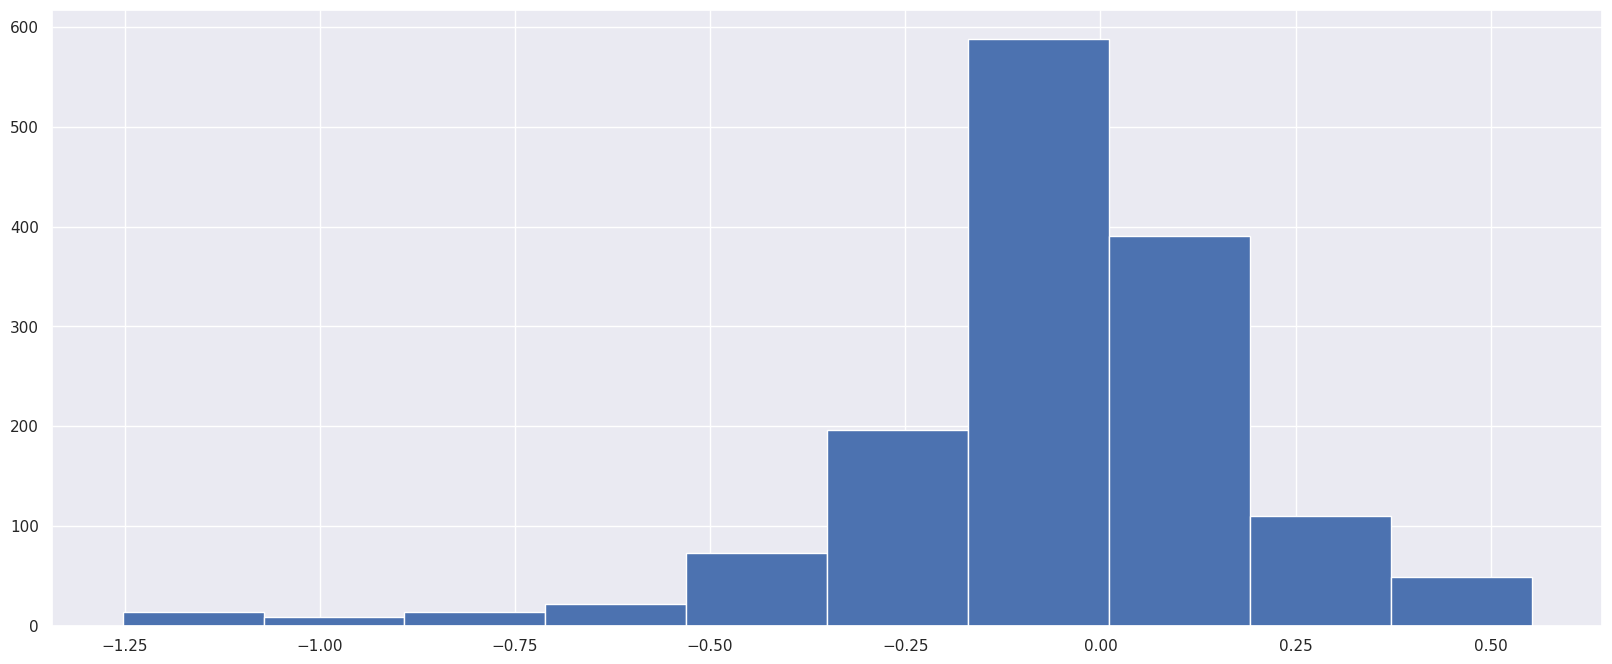

In [138]:
deviation = np.array(deviation)
arr = np.array(deviation)
arr = arr[~np.isnan(arr)]
print([round(np.quantile(deviation,i),3) for i in [0,0.01,0.05,0.95,0.99,1]])
plt.hist(deviation)

In [530]:
prices = res_plot.iloc[500:]


DAYS_PER_MONTH = 20 
print(pair)

capital = 3000000
shares = [0,0]
total = capital 
amount = 3.5
deviation = []

for i in range(0,len(prices)):
    today = prices.index[i]
    year = today.year
    month = str(today.month).zfill(2)
    
    ### Not sure why, but changing Last, can lead to significant changes in returns 
    last = calendar.monthrange(today.year,today.month)[1]

    first_date = prices.loc[f"{year}-{month}-01":,:].index[0]
    today = today.strftime('%Y-%m-%d')
    temp = prices.loc[first_date:today,:]
    
    days_past = len(temp)-1
    if temp.index[0].day > 5:
        continue

    
    bought = 0 
    action = None
    if days_past>0:
        ## Accum Return from start of month till TODAY
        return_x = (res_plot.loc[today,pair[0]]/res_plot.loc[first_date,pair[0]])**(1/days_past)-1
        return_y = (res_plot.loc[today,pair[1]]/res_plot.loc[first_date,pair[1]])**(1/days_past)-1

        ### 1) USE x-returns from start of month till now, to infer x-returns for the whole month
        ### 2) USE expected monthly x to obtain expected monthly y returns.
        ### 3) USE expected monthly y returns, to obtain expected daily y returns
        monthly_return_x = (1+return_x)**(last-1)-1
        pred_monthly_return_y = sim_returns.loc[(sim_returns[pair[0]]<monthly_return_x+0.0001)&(sim_returns[pair[0]]>monthly_return_x-0.0001),pair[1]].mean()
        # if np.isnan(pred_monthly_return_y):
        # pred_monthly_return_y = func(monthly_return_x,*popt)
        
        
        # pred_return_y = (1+pred_monthly_return_y)**(last-1)-1
        pred_return_y = (1+pred_monthly_return_y)**(1/(last-1))-1
        dev = pred_return_y - return_y
        deviation.append(dev)
        price_per_share=res_plot.loc[today,pair[1]]*1000

        
        ### Y is HUGELY under. Expected to increase by a lot. Buy ALL
        if dev < np.quantile(DEV,0.1):
            if return_x < 0:
                shares_value = capital
                amount = np.floor(shares_value/price_per_share)

                shares_value = price_per_share*(amount)
                capital-=shares_value
                shares[1]+=amount
                action="BUY"
                bought+=amount
        ## Y is HUGELY above. Expected to decrease by a lot. SELL ALL
        elif dev > np.quantile(DEV,0.9):
            if return_x > 0:
                amount = shares[1]
                capital+=price_per_share*amount
                shares[1]-=amount
                action="SELL"
                bought=0
        

#         ### Y increased proportionally more.
#         ### Y will slow down for X to catch up. 
#         if return_y > pred_return_y: 
#             ### X increasing, means Y will increase soon. Hold Y.
#             if return_x > 0:
#                 continue
#             ### X decreasing, means Y will likely decrease also. Sell Y
#             else:
#                 # print("SELL")
#                 # amount = np.ceil(-shares[1]*dev/0.15)
#                 amount = shares[1]
#                 capital+=price_per_share*amount
#                 shares[1]-=amount
#                 action="SELL"
#                 bought=0

#         ### Y increased proportionally less than X. 
#         ### Y should increase more to catch up.
#         elif return_y < pred_return_y:
#             ### X increasing, means Y will likely increase later. Buy Y
#             if return_x > 0:
#                 shares_value = min(capital*dev/0.27,capital)
#                 amount = np.floor(shares_value/price_per_share)

#                 shares_value = price_per_share*(amount)
#                 capital-=shares_value
#                 shares[1]+=amount
#                 action="BUY"
#                 bought+=amount
#             ### X decreasing, means Y will decrease soon. Hold Y
#             else:
#                 continue

        # if np.abs(dev)<0.01:
        #     # print("PROPORTIONAL")
        #     action="SELL"
        #     amount = shares[1]
        #     capital+=price_pe|r_share*amount
        #     shares[1]-=amount
        #     bought=0
        # break
        total = capital + price_per_share*shares[1]
        # if action:
            # print(action)
            # print(f"date: {today}, return_x: {np.round(return_x,3)}, return_y: {np.round(return_y,3)}, pred_return_y: {np.round(pred_return_y,3)}")
            # print(capital,shares,total,"\n")
print(capital,shares,total)
print("annualized returns:",(total/3000000)**(250/len(prices))-1)

['GSP', 'TCD']


KeyError: 'GSP'

In [189]:
deviation = np.array(deviation)
DEV = deviation.copy()
pos_dev = deviation[deviation>0]
neg_dev = deviation[deviation<0]
deviation.shape

(1033,)

In [190]:
arr = np.array(deviation)
arr = arr[~np.isnan(arr)]
np.quantile(arr,0.1)

-0.017402686096496423

In [191]:
print([round(np.quantile(deviation,i),2) for i in [0,0.01,0.05,0.1,0.9,0.95,0.99,1]])
print([round(np.quantile(pos_dev,i),2) for i in [0,0.01,0.05,0.1,0.9,0.95,0.99,1]])
print([round(np.quantile(neg_dev,i),2) for i in [0,0.01,0.05,0.1,0.9,0.95,0.99,1]])

[nan, nan, nan, nan, nan, nan, nan, nan]
[0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0.07]
[-0.08, -0.07, -0.03, -0.03, -0.0, -0.0, -0.0, -0.0]


(array([  4.,  15.,  67., 381., 426.,  90.,  12.,   6.,   1.,   2.]),
 array([-0.07496169, -0.05600678, -0.03705187, -0.01809697,  0.00085794,
         0.01981285,  0.03876776,  0.05772267,  0.07667758,  0.09563249,
         0.1145874 ]),
 <BarContainer object of 10 artists>)

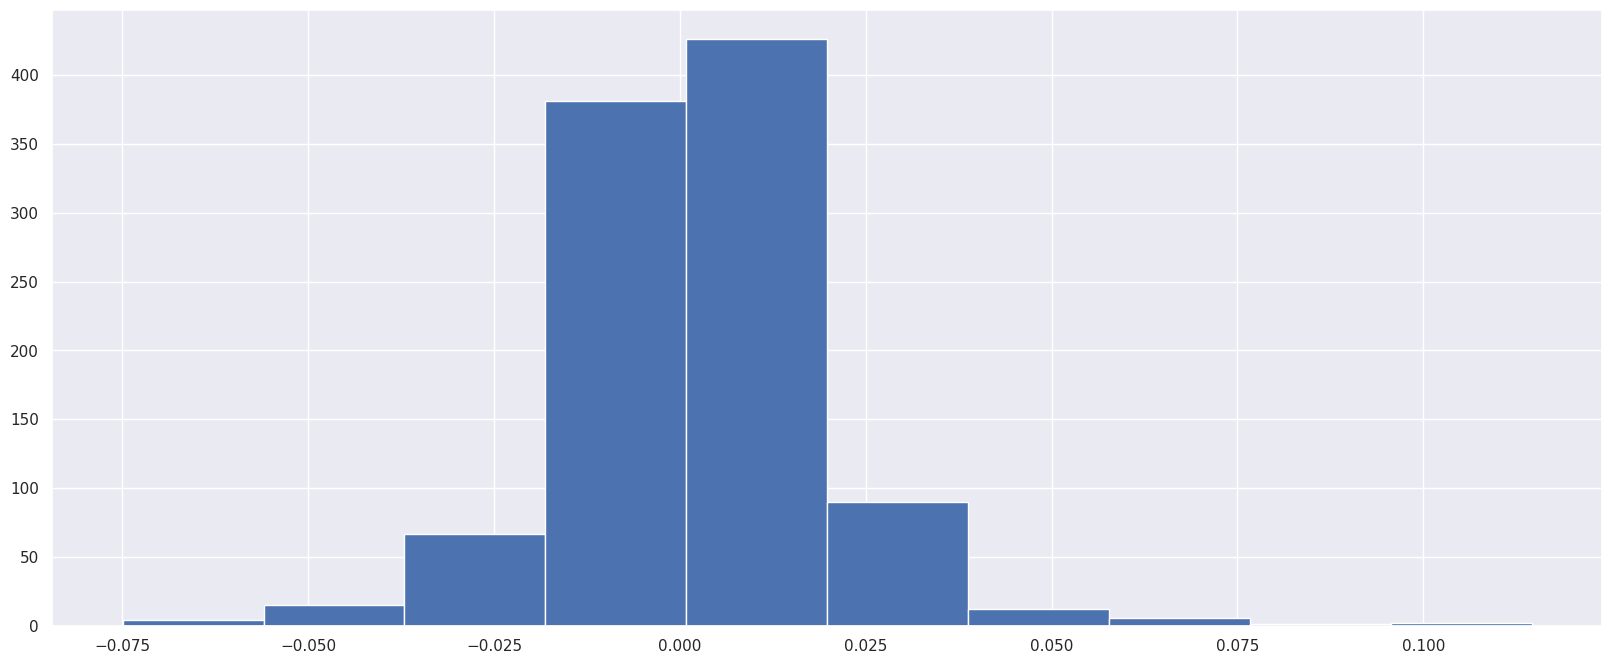

In [950]:
plt.hist(deviation)

In [918]:
from scipy import stats
percentile = stats.percentileofscore(pos_dev, 0.24)/100
percentile/100

0.0003018867924528302

In [919]:
np.percentile(pos_dev,0.29162503950334506)

0.0016872532084118192

(array([1.003e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.06216072e+00,  5.48027871e+43,  1.09605574e+44,  1.64408361e+44,
         2.19211148e+44,  2.74013935e+44,  3.28816722e+44,  3.83619509e+44,
         4.38422297e+44,  4.93225084e+44,  5.48027871e+44]),
 <BarContainer object of 10 artists>)

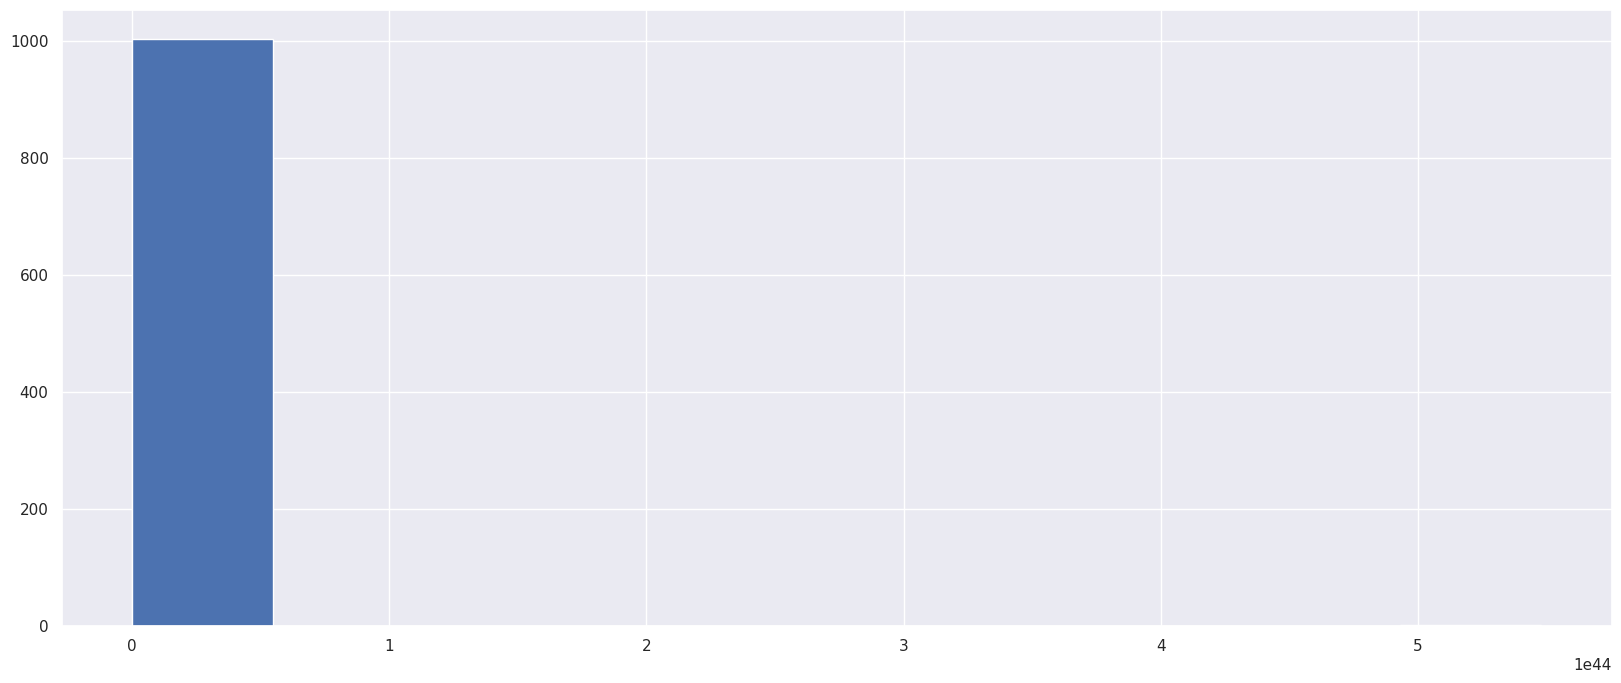

In [922]:
plt.hist(deviation)